In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import matplotlib.lines     as mlines
import os
import sys

import torch
from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150


## import own functions
sys.path.insert(1, '/lhome/silkem/MACE/MACE/src/mace')
import autoencoder  as ae
import dataset      as ds
import plotting     as pl
import training     as tr

## Species
specs_file = '/lhome/silkem/CHEM/src-IP-AP-HNR/specs/rate16_IP_6000K_Crich_mean_Htot.specs'
idxs, mols = np.loadtxt(specs_file, usecols=(0,1), unpack = True, max_rows=466, skiprows=1, dtype='str')
molecs = dict()
for i in range(len(idxs)):
    molecs[mols[i]] = int(idxs[i])-1

## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 100
epochs = 100

kwargs = {'num_workers': 1, 'pin_memory': True} 

In [2]:
dir = '/lhome/silkem/MACE/MACE/train_data_C/'

train, data_loader, test_loader = ds.get_dataset(dir, batch_size, kwargs, plot = False)

Dataset:
------------------------------
total # of samples: 2997
# training samples: 2097
# testing samples:  900
            ratio:  0.3


In [18]:
## Testing model

# Retrieve models
path = '/lhome/silkem/MACE/MACE/ae-models/learning-rate/'
model_name = 'model3'
files = os.listdir(path+model_name+'/') 
locs = []
for file in files:
    if file[-1] == 'l':
        locs.append(file)

# Abundance profile test
dir_test = '/lhome/silkem/MACE/MACE/test_data/'

x_hat = dict()
loss_train = dict()
loss_test = dict()
pred_abs = dict()

for loc in locs:
    # print('\r')
    if loc[0:5] == 'ae-lr':
        key = float(loc[5:-3])
        # print('lr:',key)

        ## get model
        model = torch.load(path+model_name+'/'+loc)

        ## get losses
        x_test, x_hat[key], loss_test[key] = tr.Test(model, test_loader, DEVICE)
        loss_train[key] = tr.validate_one_epoch(data_loader, model, DEVICE)

        ## abundance profiles
        rad, real, pred_abs[key] = tr.test_abundance_profile(dir_test, 'test', model, DEVICE, kwargs, scale = 'norm')
ae.overview(model)


Test loss model3:  0.015153671614825726
Test loss model3:  0.007791052106767893
Test loss model3:  0.0033892577048391104
Test loss model3:  0.0021675555035471916
Test loss model3:  0.08986502140760422
Test loss model3:  1.7914586067199707
Test loss model3:  0.1103050708770752
Overview model3:
___________________________________

Encoder:
       # | nodes | parameters
-----------------------------------
   input |   468 |     140700
  hidden |   300 |      90300
  hidden |   300 |       3010
  output |    10 |          /
-----------------------------------
         |       |     234010

Decoder:
       # | nodes | parameters
-----------------------------------
   input |    10 |       3300
  hidden |   300 |      90300
  hidden |   300 |     140868
  output |   468 |          /
-----------------------------------
         |       |     234468


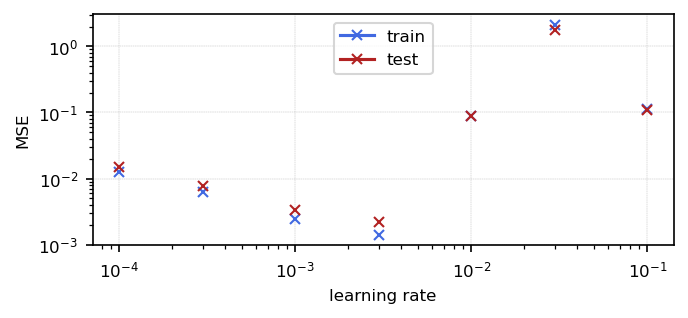

In [21]:
fig = plt.figure(figsize = (5,2))
ax1 = fig.add_subplot((111))
ms = 5
marker = 'x'

for key in loss_train:
    ax1.plot(key,loss_train[key], ls = None, marker = marker, c='royalblue', ms = ms)
    ax1.plot(key,loss_test[key] , ls = None, marker = marker, c='firebrick', ms = ms)
    # print(key, loss_train[key], loss_test[key])

train_leg = mlines.Line2D([],[], color = 'royalblue',  marker = marker, markersize=ms , label='train')
test_leg = mlines.Line2D( [],[], color = 'firebrick',  marker = marker, markersize=ms , label='test')
    
# ax1.set_ylim([1e-3,1])

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_xlabel('learning rate')
ax1.set_ylabel('MSE')

ax1.grid(True, linestyle = '--', linewidth = 0.2)
ax1.legend(handles = [train_leg, test_leg],loc = 'upper center')

plt.show()


In [22]:
for lr in pred_abs:
    print(lr)

0.0001
0.0003
0.001
0.003
0.01
0.03
0.1


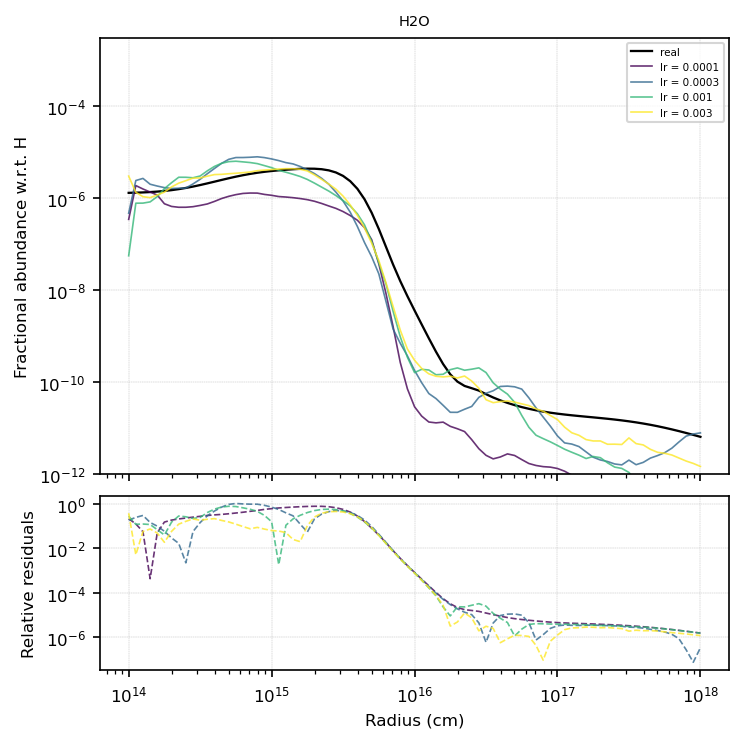

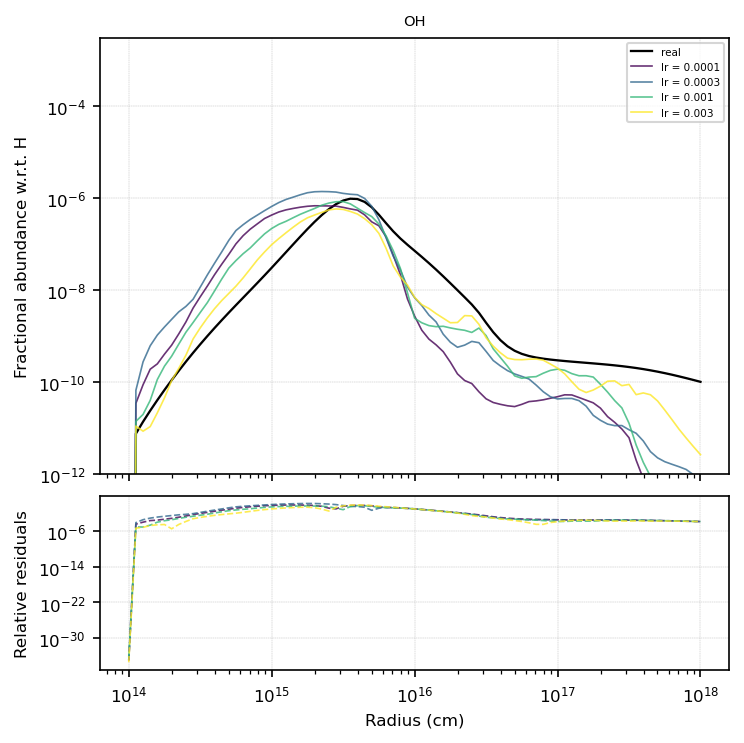

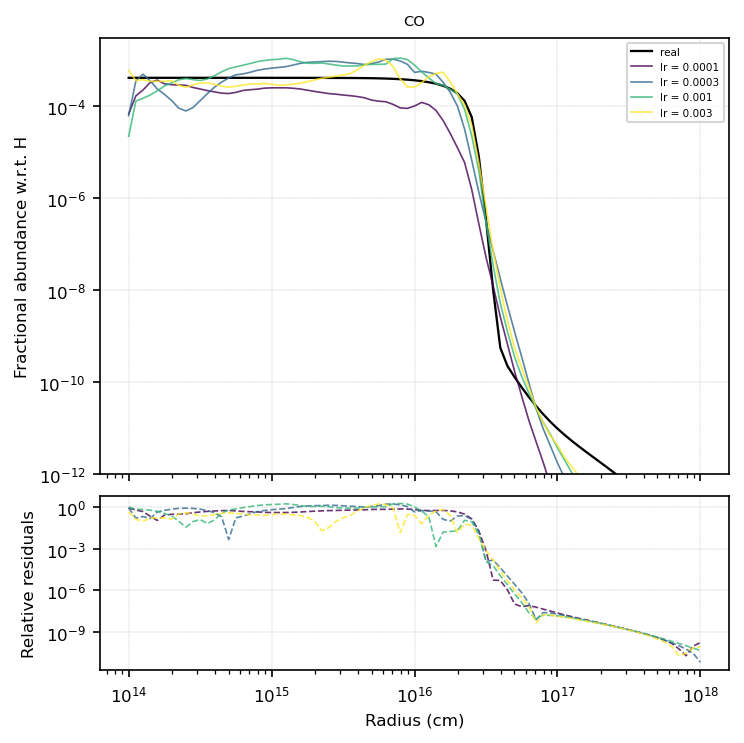

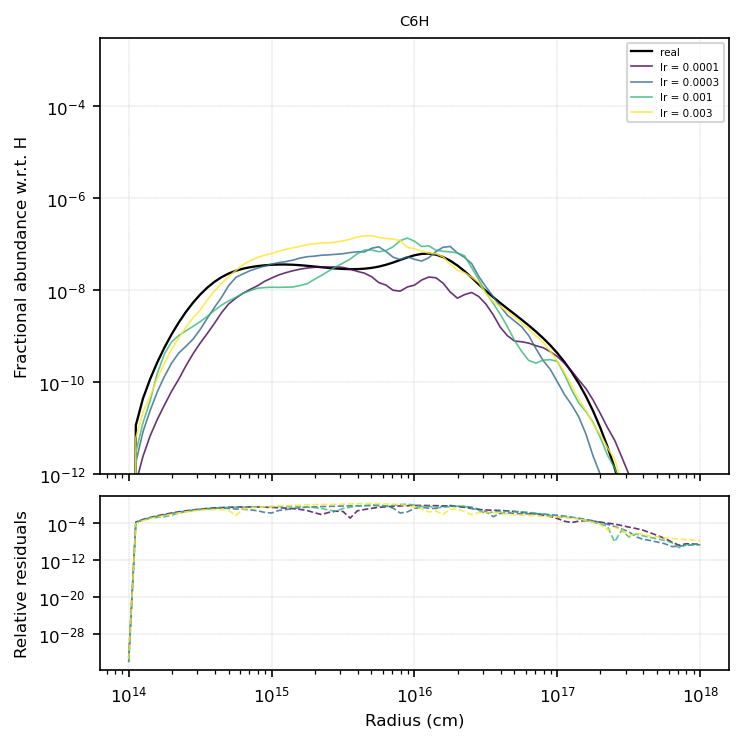

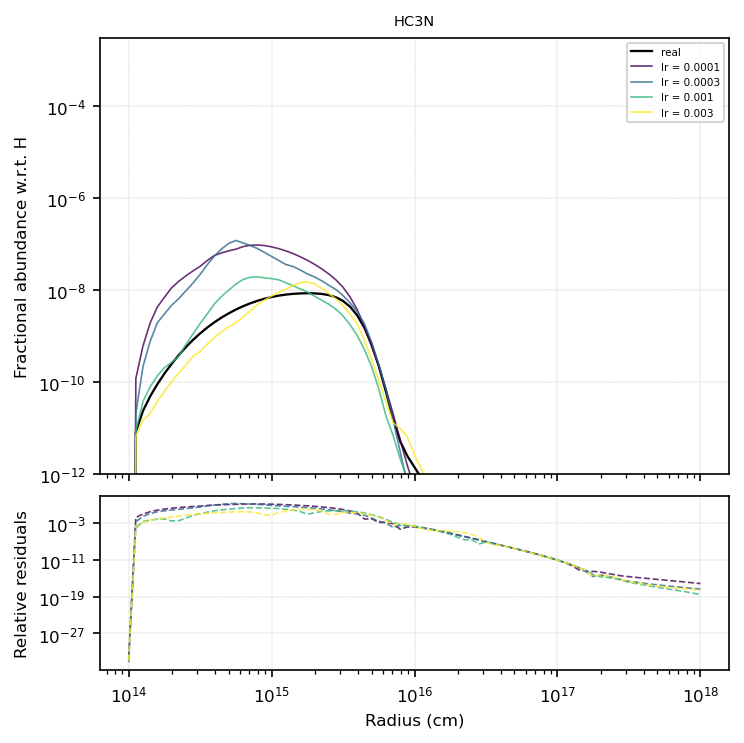

In [27]:
select = pred_abs

select = dict()
for lr in pred_abs:
    if lr > 1e-6 and lr < 1e-2:
        select[lr] = pred_abs[lr]


specs = ['H2O', 'OH','CO', 'C6H', 'HC3N']

for spec in specs:
    pl.plot_fracs_profile_lr(rad, real, select, molecs, spec)